In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture 
import torchvision
from Custom_ResNet18 import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [11]:
def create_partial_datasets(classes):
    # Load CIFAR-100 dataset
    train_data = torchvision.datasets.CIFAR100(
        root='data',
        train=True,
        transform=torchvision.transforms.ToTensor(),
        download=True
    )
    test_data = torchvision.datasets.CIFAR100(
        root='data',
        train=False,
        transform=torchvision.transforms.ToTensor(),
    )
    
    class_names = [train_data.classes[i] for i in classes]
    
    # Mapping for labels to start at 0
    mapping = {old: new for new, old in enumerate(classes)}

    # Filter and map the training dataset
    train_idx = [i for i, label in enumerate(train_data.targets) if label in classes]
    train_data.data = train_data.data[train_idx]
    train_data.targets = torch.tensor([mapping[train_data.targets[i]] for i in train_idx])

    # Filter and map the testing dataset
    test_idx = [i for i, label in enumerate(test_data.targets) if label in classes]
    test_data.data = test_data.data[test_idx]
    test_data.targets = torch.tensor([mapping[test_data.targets[i]] for i in test_idx])
    

    return train_data, test_data, class_names

def evaluate(model, test_loader):

    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1]
            correct += (pred_y == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

first_five_classes = [0,1,2,3,4,5,6,7,8,9]
second_five_classes = [10,11,12,13,14,15,16,17,18,19]
last_five_classes = [90,91,92,93,94,95,96,97,98,99]

first_train, first_test, first_classnames = create_partial_datasets(first_five_classes)
second_train, second_test, second_classnames = create_partial_datasets(second_five_classes)
last_train, last_test, last_classnames = create_partial_datasets(last_five_classes)

loaders = {
    'first_five_train': torch.utils.data.DataLoader(first_train, batch_size=100, shuffle=True, num_workers=1),
    'first_five_test': torch.utils.data.DataLoader(first_test, batch_size=100, shuffle=True, num_workers=1),
    'second_five_train': torch.utils.data.DataLoader(second_train, batch_size=100, shuffle=True, num_workers=1),
    'second_five_test': torch.utils.data.DataLoader(second_test, batch_size=100, shuffle=True, num_workers=1),
    'last_five_train': torch.utils.data.DataLoader(last_train, batch_size=100, shuffle=True, num_workers=1),
    'last_five_test': torch.utils.data.DataLoader(last_test, batch_size=100, shuffle=True, num_workers=1),
}
def train(num_epochs, train_loader, model, optimizer, loss_func, test_loader=None):
    
    test_accuracies = []
    
    model.train()
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
                        
            images = images.to(device)
            labels = labels.to(device)
            
            output = model(images)
            loss = loss_func(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # We check the test accuracy after every single epoch
        if test_loader is not None:
            accuracy = evaluate(model, test_loader)
            model.train()

            test_accuracies.append(accuracy)
        
        if (epoch+1) % 5 == 0: 
            print(f"  Finished epoch {epoch+1}")
    
    return test_accuracies

num_epochs = 30
num_models = 2

models = [custom_resnet_18(num_classes=10).to(device) for _ in range(num_models)]
optimizers = [torch.optim.Adam(model.parameters(), lr=0.01) for model in models]
loss_func = nn.CrossEntropyLoss()

print(f"Training model [{1}/{num_models}]")
#train(num_epochs, loaders["first_five_train"], models[0], optimizers[0], loss_func)
print(f"Training model [{2}/{num_models}]")
#train(num_epochs, loaders["second_five_train"], models[1], optimizers[1], loss_func)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training model [1/2]
Training model [2/2]


In [22]:
def create_initialized_model(models):
    model = custom_resnet_18(10)
    model_fl = torch.load("first_layer_init.pt")
    model.load_state_dict(model_fl)
    return model

def compare_models(models, loaders, num_epochs):
    
    random_model = custom_resnet_18(num_classes=10).to(device)
    final_model = create_initialized_model(models)
    
    random_optimizer = torch.optim.Adam(random_model.parameters(), lr=0.01)
    final_optimizer = torch.optim.Adam(final_model.parameters(), lr=0.01)
    
    loss_func = torch.nn.CrossEntropyLoss()
    
    final_accuracies = train(num_epochs, loaders["last_five_train"], final_model, final_optimizer, loss_func,
                           test_loader=loaders["last_five_test"])
    random_accuracies = train(num_epochs, loaders["last_five_train"], random_model, random_optimizer, loss_func,
                              test_loader=loaders["last_five_test"])


    return random_accuracies, final_accuracies

def get_average_score(num_iterations, models, loaders, plot_result=True):
    num_epochs = 20
    
    random_cumulative_accuracies = []
    final_cumulative_accuracies = []

    for i in range(num_iterations):
        random_accuracies, final_accuracies = compare_models(models, loaders, num_epochs)
        
        print(f"Random accuracies after 1st epoch: {random_accuracies[0]}, after 2nd epoch: {random_accuracies[1]}, after 3rd epoch {random_accuracies[2]}")
        print(f"Final accuracies after 1st epoch: {final_accuracies[0]}, after 2nd epoch: {final_accuracies[1]}, after 3rd epoch {final_accuracies[2]}")

        if not random_cumulative_accuracies:
            random_cumulative_accuracies = random_accuracies
            final_cumulative_accuracies = final_accuracies
        else:
            # Accumulate the accuracies
            random_cumulative_accuracies = [x + y for x, y in zip(random_cumulative_accuracies, random_accuracies)]
            final_cumulative_accuracies = [x + y for x, y in zip(final_cumulative_accuracies, final_accuracies)]

    # Compute the average accuracies
    random_average_accuracies = [x / num_iterations for x in random_cumulative_accuracies]
    final_average_accuracies = [x / num_iterations for x in final_cumulative_accuracies]
    
    if plot_result:
        plt.figure(figsize=(10, 6))
        plt.plot(random_average_accuracies, label='Random Model - Average Accuracy')
        plt.plot(final_average_accuracies, label='Our Model - Average Accuracy')
        plt.title('Model Comparison - Average Accuracy per Epoch')
        plt.xlabel('Epochs')
        plt.ylabel('Average Accuracy')
        plt.legend()
        plt.show()

  Finished epoch 5
  Finished epoch 10
  Finished epoch 15
  Finished epoch 20
  Finished epoch 5
  Finished epoch 10
  Finished epoch 15
  Finished epoch 20
Random accuracies after 1st epoch: 0.353, after 2nd epoch: 0.401, after 3rd epoch 0.39
Final accuracies after 1st epoch: 0.364, after 2nd epoch: 0.387, after 3rd epoch 0.415


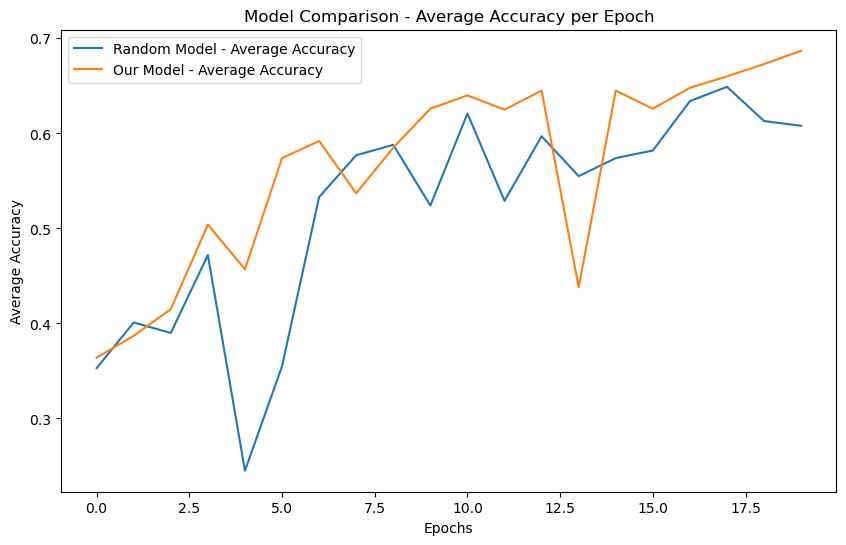

In [23]:
get_average_score(1, models, loaders)